# Setup

In [1]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport tint.process_ACCESS

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [5]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# Create Tracks

In [5]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [6]:
topog_files = open('topog_files.txt', 'r')
topog_files = topog_files.read().split('\n')[:-1]
u_files = open('u_files.txt', 'r')
u_files = u_files.read().split('\n')[:-1]
v_files = open('v_files.txt', 'r')
v_files = v_files.read().split('\n')[:-1]
maxcol_refl_files = open('maxcol_refl_files.txt', 'r')
maxcol_refl_files = maxcol_refl_files.read().split('\n')[:-1]
radar_refl_1km_files = open('radar_refl_1km_files.txt', 'r')
radar_refl_1km_files = radar_refl_1km_files.read().split('\n')[:-1]

files_list = [
    topog_files, u_files, v_files, maxcol_refl_files, radar_refl_1km_files]

dates_list = []
for files in files_list:

    dates = [f.split('/')[7] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[topog_dates, u_dates, v_dates, maxcol_refl_dates, radar_refl_1km_dates] = dates_list

In [7]:
files_63 = open('files_63.txt', 'r')
files_63 = files_63.read().split('\n')[:-1]
files_77 = open('files_77.txt', 'r')
files_77 = files_77.read().split('\n')[:-1]
files_42 = open('files_42.txt', 'r')
files_42 = files_42.read().split('\n')[:-1]

files_list = [
    files_63, files_77, files_42]

dates_list = []
for files in files_list:

    dates = [f.split('/')[9].split('_')[1] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[dates_63, dates_77, dates_42] = dates_list

In [94]:
start = np.datetime64('2020-10-01T00:00:00')
end = np.datetime64('2021-05-01T00:00:00')
datetimes_a = np.arange(start, end, np.timedelta64(10,'m'))

In [23]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes_b = np.arange(start, end, np.timedelta64(10,'m'))

In [96]:
datetimes = np.concatenate([datetimes_a, datetimes_b])

In [20]:
start = np.datetime64('2020-12-01T00:00:00')
end = np.datetime64('2020-12-02T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

In [97]:
common_dates = []
membership = []

dates_int = maxcol_refl_dates.intersection(
    radar_refl_1km_dates, dates_63, dates_42, dates_77)

G3_int = u_dates.intersection(v_dates)

for dt in datetimes:
    # Remember we use the previous day's reflectivity at 1200 
    date = np.datetime64(str(dt-np.timedelta64(1,'D'))[0:10])
    current_date = np.datetime64(str(dt)[0:10])
    hour = int(str(dt)[11:13])
    hour_round = (hour // 6) * 6
    date_hour = current_date + np.timedelta64(hour_round, 'h')
#     import pdb; pdb.set_trace()
    date_cond = date in dates_int
    hour_cond = (
        (date_hour in G3_int)
        and (date_hour + np.timedelta64(6, 'h') in G3_int))
    if date_cond:
        common_dates.append(dt)
        membership.append(1)
    else:
        membership.append(0)

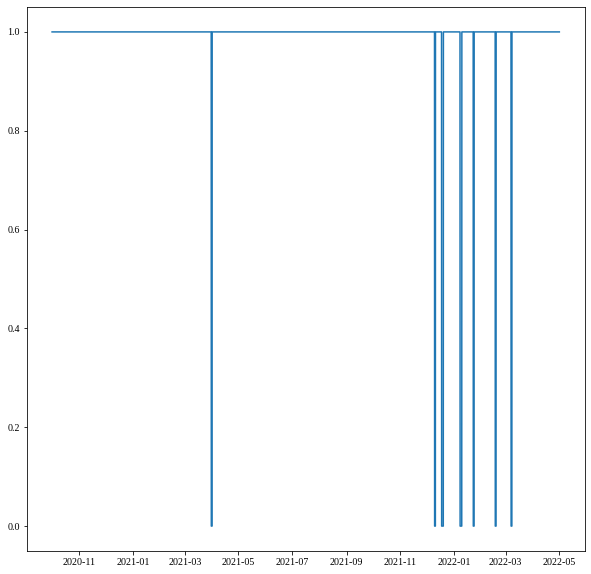

In [99]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(datetimes, membership)

In [27]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))
datetimes = sorted([d for d in datetimes if d in common_times])
datetimes

[numpy.datetime64('2021-10-01T00:00:00'),
 numpy.datetime64('2021-10-01T00:10:00'),
 numpy.datetime64('2021-10-01T00:20:00'),
 numpy.datetime64('2021-10-01T00:30:00'),
 numpy.datetime64('2021-10-01T00:40:00'),
 numpy.datetime64('2021-10-01T00:50:00'),
 numpy.datetime64('2021-10-01T01:00:00'),
 numpy.datetime64('2021-10-01T01:10:00'),
 numpy.datetime64('2021-10-01T01:20:00'),
 numpy.datetime64('2021-10-01T01:30:00'),
 numpy.datetime64('2021-10-01T01:40:00'),
 numpy.datetime64('2021-10-01T01:50:00'),
 numpy.datetime64('2021-10-01T02:00:00'),
 numpy.datetime64('2021-10-01T02:10:00'),
 numpy.datetime64('2021-10-01T02:20:00'),
 numpy.datetime64('2021-10-01T02:30:00'),
 numpy.datetime64('2021-10-01T02:40:00'),
 numpy.datetime64('2021-10-01T02:50:00'),
 numpy.datetime64('2021-10-01T03:00:00'),
 numpy.datetime64('2021-10-01T03:10:00'),
 numpy.datetime64('2021-10-01T03:20:00'),
 numpy.datetime64('2021-10-01T03:30:00'),
 numpy.datetime64('2021-10-01T03:40:00'),
 numpy.datetime64('2021-10-01T03:5

In [101]:
date_strings = list(np.array(common_dates).astype(str))
np.savetxt(
    'ACCESS_radar_common_times.csv', date_strings, delimiter =", ", fmt ='% s')

In [17]:
common_times = np.loadtxt(
    'ACCESS_radar_common_times.csv', dtype=str).astype(np.datetime64)

In [ ]:
# start = np.datetime64('2021-12-21T00:00:00')
# end = np.datetime64('2021-12-25T00:00:00')
# datetimes = np.arange(start, end, np.timedelta64(10,'m'))
# datetimes = np.array(common_dates)

micro_physics = 'ACCESS'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ACCESS', 'AMBIENT_BASE_DIR': None,
    'GS_ALT': 0,
    'LEVELS': np.array(
        [[0, 0.5], [1, 1.5]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'INPUT_TYPE': 'ACCESS_DATETIMES',
    'SAVE_DIR': save_dir,
    'REFERENCE_GRID_FORMAT': 'ODIM',
    'RESET_NEW_DAY': True,
    'REFERENCE_RADAR': 63})

grids = (
    date for date in datetimes)

tracks_obj.get_tracks(grids, b_path=b_path)

Creating a reference grid.
Interpolating ACCESS-C reflectivity at 2021-10-01T00:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/consts.py:114: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return getattr(value, expr.attr)
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/ir_utils.py:2097: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int

Getting ACCESS-G ambient winds at 2021-10-01T00:00:00.000000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 0.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11.


Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 104.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 107.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 108.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 109.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 110.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 112.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 115.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 225.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 226.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 227.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 231.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 232.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 233.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 234.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 235.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-03T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-03T06:00:00.000000.
Writing tracks for scan 324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 325.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 326.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 327.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 328.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 329.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 330.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 331.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 332.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 333.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 334.
Up

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 430.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 431 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-04T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-04. Resetting objects.
No objects found in scan 432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 440.
Updating ACCESS-C 

Getting ACCESS-G ambient winds at 2021-10-04T19:20:00.000000.
Writing tracks for scan 548.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 549.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 550.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 551.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 552.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 553.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 554.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 555.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 556.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 557.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 558.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 559.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 646.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 650.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 651.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 652.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 653.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 654.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 655.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 656.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 657.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 658.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-06T04:40:00.000000.
Getting ACCESS-G ambient winds at 2021-10-06T04:40:00.000000.
Writing tracks for scan 748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 749.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 750.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 751.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 752.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 754.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 755.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 756.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 757.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7

No objects found in scan 860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 862.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 863 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-07T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-07. Resetting objects.
No objects found in scan 864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found i

No objects found in scan 972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 975.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 976.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 977.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 982.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 983.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 984.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1095.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1096.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1097.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1098.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1099.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1100.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1101.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1102.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1103.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1104.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1106.
Updating ACCESS-C pseudo pya

No objects found in scan 1202.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1203.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1204.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1210.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1211.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1212.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1213.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 121

Getting ACCESS-G ambient winds at 2021-10-10T03:00:00.000000.
Writing tracks for scan 1314.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1315.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1316.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1317.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1318.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1319.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1320.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1321.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1322.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1323.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1325.
Updating ACCESS-C pse

No objects found in scan 1426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1430.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 143

No objects found in scan 1528.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1529.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1530.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1531.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1532.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1533.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1534.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1535.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1536.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1537.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1538.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1539.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 154

Getting ACCESS-G ambient winds at 2021-10-12T08:20:00.000000.
Writing tracks for scan 1634.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1635.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1636.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1637.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1638.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1639.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1640.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1641.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1642.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1643.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1644.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1645.
Updating ACCESS-C

Getting ACCESS-G ambient winds at 2021-10-13T03:40:00.000000.
Writing tracks for scan 1750.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1751.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1752.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1753.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1754.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1755.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1756.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1757.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1758.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1759.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1760.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1761.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-10-14T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-14. Resetting objects.
No objects found in scan 1872.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1873.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1874.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1875.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1876.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1877.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1878.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1879.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1880.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1881.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1882.
Updatin

No objects found in scan 1997.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1998.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1999.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2001.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2002.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2003.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2004.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2005.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2006.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2007.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 200

No objects found in scan 2117.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2118.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2119.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2120.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2121.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2123.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2124.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2125.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2126.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2127.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 212

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2221.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2222.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2225.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2226.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2227.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2231.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2232.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-10-17T03:50:00.000000.
Writing tracks for scan 2327.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2328.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2329.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2330.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2331.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2332.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2333.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2334.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2335.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2336.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2337.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2338.
Updating ACCESS-C pseudo pya

No objects found in scan 2442.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2443.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2444.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2445.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2446.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 2447 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-18T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-18. Resetting objects.
No objects found in scan 2448.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2449.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2450.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2451.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2452.
Updating ACCESS-C pseudo pyart reflectivity grid.
No obje

No objects found in scan 2556.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2557.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2558.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2559.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2560.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2561.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2562.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2563.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2564.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2565.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2566.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2567.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 256

No objects found in scan 2655.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2656.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2657.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2658.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2659.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2660.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2661.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2662.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2663.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2664.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2665.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2666.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 266

Getting ACCESS-G ambient winds at 2021-10-20T03:30:00.000000.
Writing tracks for scan 2757.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2758.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2759.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2760.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2761.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2762.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2763.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2764.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2765.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2766.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2767.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2768.
Updating ACCESS-C pseudo pya

No objects found in scan 2877.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2878.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 2879 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-21T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseu

Writing tracks for scan 2965.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2966.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2967.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2968.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2969.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2970.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2971.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2972.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2973.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2974.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2975.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-21T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-21T18:00:00.000

Writing tracks for scan 3053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3056.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3057.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3058.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3059.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3060.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3061.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3062.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3063.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3064.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3065.
Updating A

Updating ACCESS-G ambient winds at 2021-10-23T03:40:00.000000.
Getting ACCESS-G ambient winds at 2021-10-23T03:40:00.000000.
Writing tracks for scan 3169.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3170.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3171.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3172.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3173.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3174.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3175.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3176.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3177.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3178.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3179.
Updating ACCESS-C pseudo pyart reflectivity g

Interpolating ACCESS-C reflectivity at 2021-10-24T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-24. Resetting objects.
No objects found in scan 3291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3295.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3297.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3298.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3299.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3300.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3301.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3430.
Updating ACCESS-C pseudo pya

No objects found in scan 3523.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3524.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3525.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3526.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3527.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3528.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3529.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3530.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3531.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3532.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3533.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3534.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 353

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3641.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3642.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3643.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3644.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3645.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-26T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-26T12:00:00.000000.
Writing tracks for scan 3646.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3647.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3648.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3650.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in sc

No objects found in scan 3742.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-27T04:10:00.000000.
Getting ACCESS-G ambient winds at 2021-10-27T04:10:00.000000.
Writing tracks for scan 3743.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3744.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3745.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3746.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3747.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3748.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3749.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3750.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3751.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3752.
Updating ACCESS-C pseudo pyart reflectivity 

Interpolating ACCESS-C reflectivity at 2021-10-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-28. Resetting objects.
No objects found in scan 3862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3872.
Updatin

No objects found in scan 3963.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 397

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4061.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4062.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4068.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4069.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4070.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4072.
Updating ACCESS-C pseudo pya

Writing tracks for scan 4160.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4161.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4162.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4163.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4164.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4165.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4166.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4167.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4168.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4169.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4170.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4171.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-

No objects found in scan 4268.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4269.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4270.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4271.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4272.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4273.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4274.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4275.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4276.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4278.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 4279 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-31T00:10:00.
Updating ACCESS-C 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4388.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4389.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4390.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4391.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4392.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4393.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4394.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4395.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4396.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4397.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4398.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4399.
Updating ACCESS-C pseudo pya

Writing tracks for scan 4487.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4488.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4489.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4490.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4491.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4492.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4493.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4494.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4495.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4496.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4497.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4498.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4499

Getting ACCESS-G ambient winds at 2021-11-02T04:10:00.000000.
Writing tracks for scan 4593.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4594.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4595.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4596.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4597.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4598.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4599.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4600.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4601.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4602.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4603.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-02T06:00:00.000

Interpolating ACCESS-C reflectivity at 2021-11-03T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-03. Resetting objects.
No objects found in scan 4712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4722.
Updatin

Writing tracks for scan 4811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4813.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4814.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4815.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4816.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4817.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4818.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4819.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4820.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4821.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4822.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4823.
Upda

Getting ACCESS-G ambient winds at 2021-11-04T10:50:00.000000.
Writing tracks for scan 4921.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4923.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4924.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4925.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4926.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4927.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4928.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4929.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4930.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4931.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4932.
Updating ACCESS-C pse

Getting ACCESS-G ambient winds at 2021-11-05T03:20:00.000000.
Writing tracks for scan 5013.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5014.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5017.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5018.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5019.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5020.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5021.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5022.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5023.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5024.
Updating ACCESS-C pseudo p

In [43]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + '42_2020_2021_{}.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [50]:
test = np.datetime64('2020-01-01')
# test + np.timedelta64(1, 'M')
test

a = np.datetime64('1995-12-01')
b = pd.Timestamp(a) + pd.DateOffset(months=1)
np.datetime64(b)

numpy.datetime64('1996-01-01T00:00:00.000000')

In [61]:
test = [
    d for d in datetimes 
    if (int(str(d)[0:4])==2020 and int(str(d)[5:7])==11)]
test[0]

numpy.datetime64('2020-11-01T00:00:00')

In [42]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [16]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()

In [19]:
tracks_obj.tracks

center     com_x    com_y  \
scan time                uid level                                     
452  2021-12-24 03:20:00 0   0       [50.0, 39.0]  -53108.2 -26544.1   
                             1       [48.0, 39.0]  -53271.0 -30014.1   
453  2021-12-24 03:30:00 0   0       [49.0, 39.0]  -55669.5 -29237.0   
                             1       [47.0, 38.0]  -56753.1 -31307.4   
456  2021-12-24 04:00:00 1   0       [51.0, 43.0]  -46807.5 -22333.7   
...                                           ...       ...      ...   
480  2021-12-24 08:00:00 4   1      [70.0, 105.0]  111553.6  23235.4   
481  2021-12-24 08:10:00 4   0      [63.0, 100.5]  102298.9   8022.8   
                             1      [69.0, 104.0]  109498.9  21523.8   
486  2021-12-24 09:00:00 5   0        [62.5, 7.0] -131799.8   6384.6   
                             1       [63.0, 14.0] -116330.3   7283.0   

                                           grid_x        grid_y  proj_area  \
scan time                uid level                                           
452  2021-12-24 03:20:00 0   0      -57182.912827 -31448.163986     300.00   
                             1      -57813.987732 -33498.916626     850.00   
453  2021-12-24 03:30:00 0   0      -60189.437866 -33493.909836     362.50   
                             1      -58956.260681 -34640.865326     831.25   
456  2021-12-24 04:00:00 1   0      -48651.371002 -22980.098724     306.25   
...                                           ...           ...        ...   
480  2021-12-24 08:00:00 4   1      108967.857361  23616.542816    1668.75   
481  2021-12-24 08:10:00 4   0      102042.884827   8141.365051      87.50   
                             1      107192.230225  21999.168396    1656.25   
486  2021-12-24 09:00:00 5   0     -132349.513769   6466.093063     162.50   
                             1     -115000.000000   7500.000000     956.25   

                                          lon       lat  field_max  \
scan time                uid level                                   
452  2021-12-24 03:20:00 0   0      131.91411 -14.79522      55.72   
                             1      131.90819 -14.81365      57.34   
453  2021-12-24 03:30:00 0   0      131.88610 -14.81355      52.55   
                             1      131.89754 -14.82389      56.21   
456  2021-12-24 04:00:00 1   0      131.99362 -14.71923      60.08   
...                                       ...       ...        ...   
480  2021-12-24 08:00:00 4   1      133.45730 -14.29845      52.87   
481  2021-12-24 08:10:00 4   0      133.39362 -14.43788      45.45   
                             1      133.44089 -14.31307      50.02   
486  2021-12-24 09:00:00 5   0      131.21685 -14.45165      56.15   
                             1      131.37802 -14.44314      57.54   

                                    max_height  ...   v   x_vert_disp  \
scan time                uid level              ...                     
452  2021-12-24 03:20:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   -631.074905   
453  2021-12-24 03:30:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   1233.177185   
456  2021-12-24 04:00:00 1   0           0.000  ... NaN           NaN   
...                                        ...  ...  ..           ...   
480  2021-12-24 08:00:00 4   1           0.001  ... NaN  -9092.025757   
481  2021-12-24 08:10:00 4   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   5149.345398   
486  2021-12-24 09:00:00 5   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN  17349.513769   

                                     y_vert_disp  u_ambient_mean  \
scan time                uid level                                 
452  2021-12-24 03:20:00 0   0               NaN        -4.12677   
                          

In [40]:
with open(save_dir + 'ACCESS_77/20201001_20210501.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [45]:
datetimes[8091]

numpy.datetime64('2020-11-26T04:30:00')

In [19]:
plot_datetime = datetimes[2241]

In [36]:
plot_datetime = np.datetime64('2021-12-24 07:40:00')

In [37]:
ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

Generating figure for 2021-12-24T07:40.


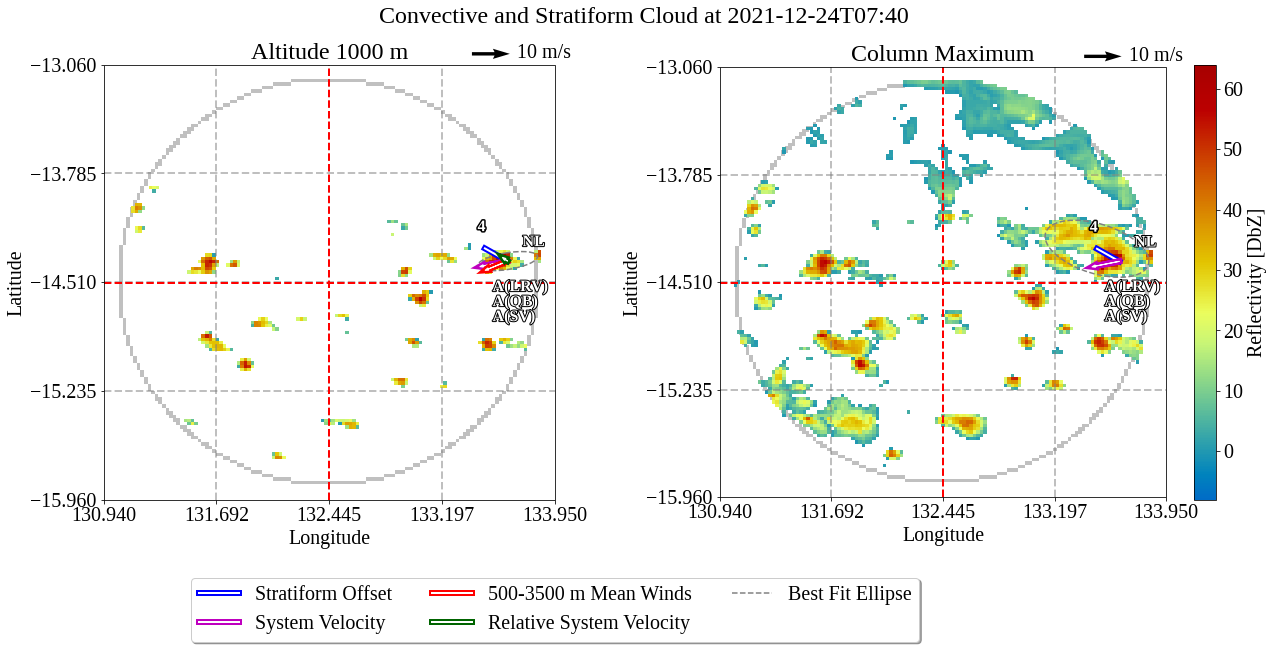

In [38]:
# filename = filenames[12]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')